## Linear and Polynomial Regression for Skyrmion trajectories prediction

**Imports**

In [1]:
# Standard imports
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

import trackpy as tp

from tqdm import tqdm  # for progress bar

import random
import cv2

**Useful functions**

In [2]:
# Preprocess data fro the specified directory
def preprocess(directory=''):
    # read data
    data = pd.read_csv(directory + '/trajectories.csv')
    
    # drop unused columns
    unused_columns = ['Unnamed: 0', 'mass', 'size', 'ecc', 'signal', 'raw_mass', 'ep']

    data = data.drop(columns=unused_columns)
    
    # fill missing values
    no_skyrmions = data[data['frame'] == 0].shape[0]
    
    ids = list(range(no_skyrmions))

    # iterate through the frames
    for f in tqdm(data['frame'].unique()):
        for p in range(no_skyrmions):
            # this means the skyrmion p is missing in frame f
            if not any(data[data['frame'] == f]['particle'] == p):

                # find previous coorinates
                x_prev = data[(data['frame'] == f-1) & (data['particle'] == p)]['x'].values[0]
                y_prev = data[(data['frame'] == f-1) & (data['particle'] == p)]['y'].values[0]

                x_next = x_prev
                y_next = y_prev

                #find next coordinates
                for next_frame in range((f+1).astype(int), len(data['frame'].unique())):
                    if any(data[data['frame'] == f]['particle'] == p):
                        x_next = data[(data['frame'] == next_frame) & (data['particle'] == p)]['x'].values[0]
                        y_next = data[(data['frame'] == next_frame) & (data['particle'] == p)]['y'].values[0]
                        break

                # new coordinates
                x_new = (x_prev + x_next) / 2
                y_new = (y_prev + y_next) / 2

                data = data.append({'y' : y_new,
                                    'x' : x_new,
                                    'frame' : f,
                                    'particle': p}, ignore_index=True)
                
    data = data.sort_values(by=['frame', 'particle'])
    return data

In [3]:
# Put data in frames format
def get_frames(data):
    frames = []

    # iterate through the frames
    for f in tqdm(data['frame'].unique()):
        coordinates = None
        for p in data[data['frame'] == f]['particle']:
            particle = data[(data['frame'] == f) & (data['particle'] == p)]
            coordinates = np.append(coordinates, [particle['x'].values[0], particle['y'].values[0]]) if coordinates is not None else [particle['x'].values[0], particle['y'].values[0]]
        frames.append(list(coordinates))
    return frames

In [4]:
# Split in training and testing
def split(df, test_size = 0.2):
    last_x_pct = df.index.values[-int(test_size*len(frames))]
    val_df = df[(df.index >= last_x_pct)]
    df = df[(df.index < last_x_pct)]
    
    first_col = df.columns[0]
    second_col = df.columns[1]
    
    return df[first_col].tolist(), df[second_col].tolist(), val_df[first_col].tolist(), val_df[second_col].tolist()

In [5]:
from sklearn.metrics import mean_squared_error, r2_score

# Print evaluation metrics
def evaluate(X, y):
    y_predict = lin_model.predict(X)
    rmse = (np.sqrt(mean_squared_error(y, y_predict)))
    r2 = r2_score(y, y_predict)
    
    print("--------------------------------------")
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))
    print("\n")
    
    return y_predict

In [6]:
from sklearn.preprocessing import PolynomialFeatures

# Perform and evaluate poly regression
def create_polynomial_regression_model(degree):
    poly_features = PolynomialFeatures(degree=degree)

    # transform the features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train)

    # fit the transformed features to Linear Regression
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)

    # predicting on training data-set
    y_train_predicted = poly_model.predict(X_train_poly)

    # predicting on test data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))

    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
    r2_train = r2_score(y_train, y_train_predicted)

    # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
    r2_test = r2_score(y_test, y_test_predict)

    print("The model performance for the training set")
    print("-------------------------------------------")
    print("RMSE of training set is {}".format(rmse_train))
    print("R2 score of training set is {}".format(r2_train))

    print("\n")

    print("The model performance for the test set")
    print("-------------------------------------------")
    print("RMSE of test set is {}".format(rmse_test))
    print("R2 score of test set is {}".format(r2_test))

In [7]:
def show_tracked(df):
    print('Tracked particles on first frame')
    img = cv2.imread(directory + '/m000000.png')
    radius = 10
    color = (255, 0, 0)
    thickness = 2

    for index, row in df[df['frame'] == 0].iterrows():
        img = cv2.circle(img, (int(row['x']), int(row['y'])), radius, color, thickness) 

    plt.figure(figsize=(20, 10))
    plt.imshow(img)
    plt.show()

In [8]:
def get_predictions_df(y_predict):
    predict_df = pd.DataFrame(columns=['x', 'y', 'frame', 'particle'])

    for i in tqdm(range(len(y_predict))):
        for j in range(0, len(y_predict[i]), 2):
            predict_df = predict_df.append({'x': y_predict[i][j], 'y':y_predict[i][j+1], 'frame': i, 'particle': j//2}, ignore_index=True)
    
    return predict_df

In [9]:
def plot_prediction(train_predict_df, test_predict_df, data, particle=0):
    plt.figure(figsize=(20, 10))
    plt.grid(True, axis='x')
    plt.xticks(np.arange(0, max(data['x'])+1, 1000.0))
    plt.ylim(0, 200)
    plt.gca().invert_yaxis()
    plt.axvline(x=train_predict_df[train_predict_df['particle'] == particle]['x'].iloc[-1], ymin=0, ymax=1, label='training vs testing', color='g')

    x = pd.concat([train_predict_df[train_predict_df['particle'] == particle]['x'], test_predict_df[test_predict_df['particle'] == particle]['x']])
    y = pd.concat([train_predict_df[train_predict_df['particle'] == particle]['y'], test_predict_df[test_predict_df['particle'] == particle]['y']])

    plt.plot(x, y, label='prediction')
    plt.plot(data[data['particle'] == particle]['x'], data[data['particle'] == particle]['y'], label='ground truth')
    plt.legend()

## Experiment 1: Predict next frame given one frame

**Preprocess data**

In [10]:
directory = 'Rec_EDGE_300K_1L_50MA.out'
data = preprocess(directory)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.44it/s]


Tracked particles on first frame


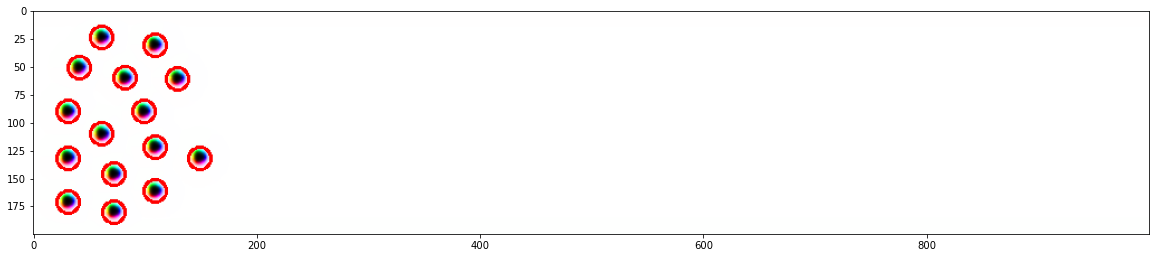

In [11]:
show_tracked(data)

**Format the data so that it is in the format (frame, next_frame)**

In [12]:
frames = get_frames(data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 125.31it/s]


**Place data in DataFrame**

In [13]:
# data in columns ['frame', 'next_frame']
df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(frames)):
    df = df.append({'frame': frames[i-1], 'next_frame': frames[i]}, ignore_index=True)

**Split data for training and testing**

In [14]:
X_train, y_train, X_test, y_test = split(df, 0.2)

**Train model with Linear Regression**

In [15]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

**Model evaluation**

In [16]:
print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test)

The model performance for X_train
--------------------------------------
RMSE is 3.4152481503624488
R2 score is 0.9853483155086447


The model performance for X_test
--------------------------------------
RMSE is 5.936735480105207
R2 score is 0.8322270280667479




In [17]:
train_predict_df = get_predictions_df(y_predict_train)
test_predict_df = get_predictions_df(y_predict_test)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:03<00:00, 52.03it/s]


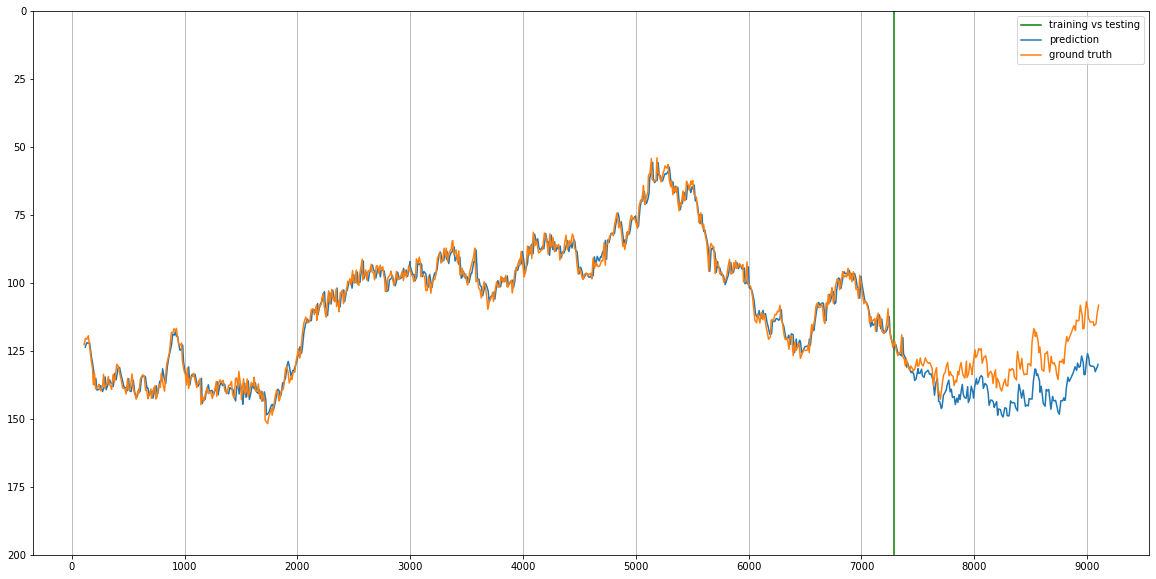

In [18]:
plot_prediction(train_predict_df, test_predict_df, data, particle=8)

**Train and evaluate Polynoial Regression**

In [19]:
create_polynomial_regression_model(2)

The model performance for the training set
-------------------------------------------
RMSE of training set is 5.025366116188169
R2 score of training set is 0.9316630694508846


The model performance for the test set
-------------------------------------------
RMSE of test set is 260.7557949703331
R2 score of test set is -375.4158506202287


In [20]:
create_polynomial_regression_model(3)

The model performance for the training set
-------------------------------------------
RMSE of training set is 1.7129989457285962e-08
R2 score of training set is 1.0


The model performance for the test set
-------------------------------------------
RMSE of test set is 715.2248402472886
R2 score of test set is -1181.347934694499


## Experiment 2: how many frames in the future can I predict given one frame?

**Try to predict n frames in the future**

In [21]:
n = 5

# data in format (frame, next n frames)
dfn = pd.DataFrame(columns=['X', 'y'])

for i in range(n, len(frames)):
    target = []
    for j in range(n-1, -1, -1):
        target = target + frames[i-j]
    dfn = dfn.append({'X': frames[i-2], 'y': target}, ignore_index=True)

In [22]:
X_train, y_train, X_test, y_test = split(dfn, 0.2)

**Linear Regression**

In [23]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [24]:
print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test)

The model performance for X_train
--------------------------------------
RMSE is 3.3078562701778664
R2 score is 0.9858660451377333


The model performance for X_test
--------------------------------------
RMSE is 6.3404056232005095
R2 score is 0.8420766420553342




**Poly regression**

In [25]:
create_polynomial_regression_model(2)

The model performance for the training set
-------------------------------------------
RMSE of training set is 1.2712673881880174
R2 score of training set is 0.9979371011566074


The model performance for the test set
-------------------------------------------
RMSE of test set is 147.95375364893425
R2 score of test set is -79.4920119365813


In [26]:
create_polynomial_regression_model(3)

The model performance for the training set
-------------------------------------------
RMSE of training set is 2.2904825149409633e-08
R2 score of training set is 1.0


The model performance for the test set
-------------------------------------------
RMSE of test set is 613.001485288703
R2 score of test set is -1109.7433838074228


We can see that if we set the target as the next n frames and train with samples of the form (frame, next n frames), the model performs quite well with a linear model, but e polynomial one overfits the training data. This is the same result as the case in which we try to predict only one frame. But we are more interested in predicting multiple frames in the future give a sample of the form (frame, next frames), which we will look at in the next section.

## Experiment 3: how are the results affected if I try to predict on using my prediction as input data? For how many rounds can this be accurate enough?

**Try to predict n times**

In [27]:
n = 50

# data in columns format (frame, next frame, next next frame, ...)
df_n_rounds = pd.DataFrame(columns=['X', 'y_1'])

for i in range(1, n):
    df_n_rounds['y_' + str(i+1)] = ''

for i in range(n+1):
    col = []
    for j in range(i, len(frames)-n+i):
        col.append(frames[j])
    if i == 0:
        df_n_rounds['X'] = col
    else:
        df_n_rounds['y_' + str(i)] = col

In [28]:
X_train, y_train, X_test, y_test = split(df_n_rounds, 0.2)

We train the model in the first two columns.

**Linear Regression**

In [29]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [30]:
print("The model performance for training set")
evaluate(X_train, y_train)

print("The model performance for testing set")
evaluate(X_test, y_test)

The model performance for training set
--------------------------------------
RMSE is 3.4020292460683392
R2 score is 0.9810654066891086


The model performance for testing set
--------------------------------------
RMSE is 6.154335805426999
R2 score is 0.8267289646340397




array([[6716.76218679,  158.39658887, 6644.05699819, ...,  151.61906493,
        6417.85193395,  128.75921605],
       [6730.75363428,  159.76247986, 6656.68684733, ...,  146.71316459,
        6430.2014197 ,  125.09275462],
       [6736.09521122,  163.5803758 , 6671.60368248, ...,  147.37536556,
        6439.97667514,  124.45986197],
       ...,
       [8473.18215437,  147.36948105, 8392.9003775 , ...,  144.79568844,
        8122.07254346,   95.37289786],
       [8477.37168858,  150.05179156, 8402.5945645 , ...,  145.06611449,
        8136.08891341,   97.10432611],
       [8490.23846975,  149.17802087, 8414.37711929, ...,  143.58058792,
        8145.14415909,   96.57370393]])

The result is as the case of linear regression, as expected. We will not look at polynomial regression as it clearly overfits.

In [31]:
y_i_predict =  lin_model.predict(X_train+X_test)
for i in range(1, n):
    print("The model performance for y_{} -> y_{}".format(i, i+1))
    evaluate(df_n_rounds['y_' + str(i+1)].tolist(), y_i_predict)

The model performance for y_1 -> y_2
--------------------------------------
RMSE is 15.987475137482168
R2 score is 0.9845406204637314


The model performance for y_2 -> y_3
--------------------------------------
RMSE is 23.71768451707156
R2 score is 0.9785871606995876


The model performance for y_3 -> y_4
--------------------------------------
RMSE is 31.470606685775465
R2 score is 0.9724657921981668


The model performance for y_4 -> y_5
--------------------------------------
RMSE is 39.232534242511136
R2 score is 0.9662743486326878


The model performance for y_5 -> y_6
--------------------------------------
RMSE is 46.998553024448505
R2 score is 0.9599075960928111


The model performance for y_6 -> y_7
--------------------------------------
RMSE is 54.76934292882466
R2 score is 0.9531028249448075


The model performance for y_7 -> y_8
--------------------------------------
RMSE is 62.54052126318593
R2 score is 0.946704091355726


The model performance for y_8 -> y_9
---------------

We can see that the performance gets worse when predicting more frames in the future, but this is to be expected as we are going further and further from the ground truth. But the results are still pretty good as we can see 50 frames in the future with a small error.

## Analyse behaviour of subsets of skyrmions (only cosider the ones in the top half, bottom half, centre)

In [32]:
# top qurter
top = data.copy()
# bottom qurter
bottom = data.copy()
# middle quarter
centre = data.copy()

# drop particles that do not start in the top/bottom/centre of the 
# construct top
particles_to_keep = []
for index, row in data[data['frame'] == 0].iterrows():
    if row['y'] < max(data['y']) / 4:
        particles_to_keep.append(row['particle'])
        
for index, row in tqdm(top.iterrows()):
    if row['particle'] not in particles_to_keep:
        top = top.drop(index)

# construct bottom
particles_to_keep = []
for index, row in data[data['frame'] == 0].iterrows():
    if row['y'] > 3 * (max(data['y']) / 4):
        particles_to_keep.append(row['particle'])
        
for index, row in tqdm(bottom.iterrows()):
    if row['particle'] not in particles_to_keep:
        bottom = bottom.drop(index)

# construct centre
particles_to_keep = []
for index, row in data[data['frame'] == 0].iterrows():
    if row['y'] > 3 * (max(data['y']) / 8) and row['y'] < 5 * (max(data['y']) / 8):
        particles_to_keep.append(row['particle'])
        
for index, row in tqdm(centre.iterrows()):
    if row['particle'] not in particles_to_keep:
        centre = centre.drop(index)

12000it [00:05, 2173.04it/s]
12000it [00:05, 2370.84it/s]
12000it [00:05, 2252.36it/s]


**Analyse Top**

In [33]:
top.describe()

,y,x,frame,particle
count,1600.000000,1600.000000,1600.00000,1600.000000
mean,91.646874,4534.113318,399.50000,0.500000
std,35.653440,2577.574292,231.01213,0.500156
min,15.109391,61.809992,0.00000,0.000000
25%,69.341467,2294.652841,199.75000,0.000000
50%,87.821167,4522.438422,399.50000,0.500000
75%,113.762225,6771.479529,599.25000,1.000000
max,177.842924,9030.630412,799.00000,1.000000


Tracked particles on first frame


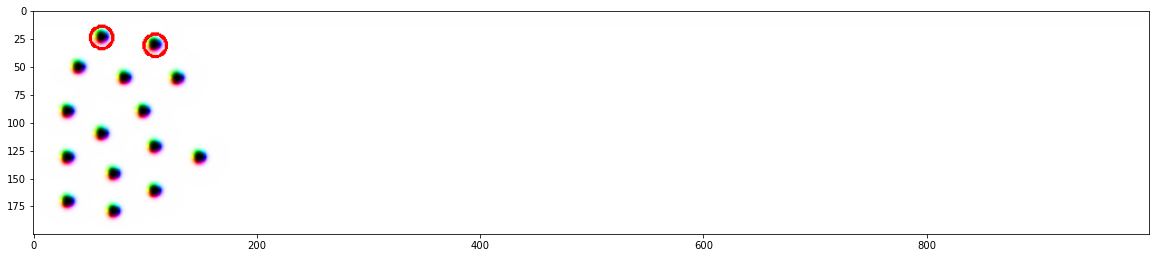

In [34]:
show_tracked(top)

The skyrmions move throughout the entire y-axis. Of course their behaviour is influences by other skyrmions in the ensamble as well. But it seems like there is no tendency of skyrmoins remaining at the top when startin there. This can be observed in both the plot and the tbale above (mean is close to 100).

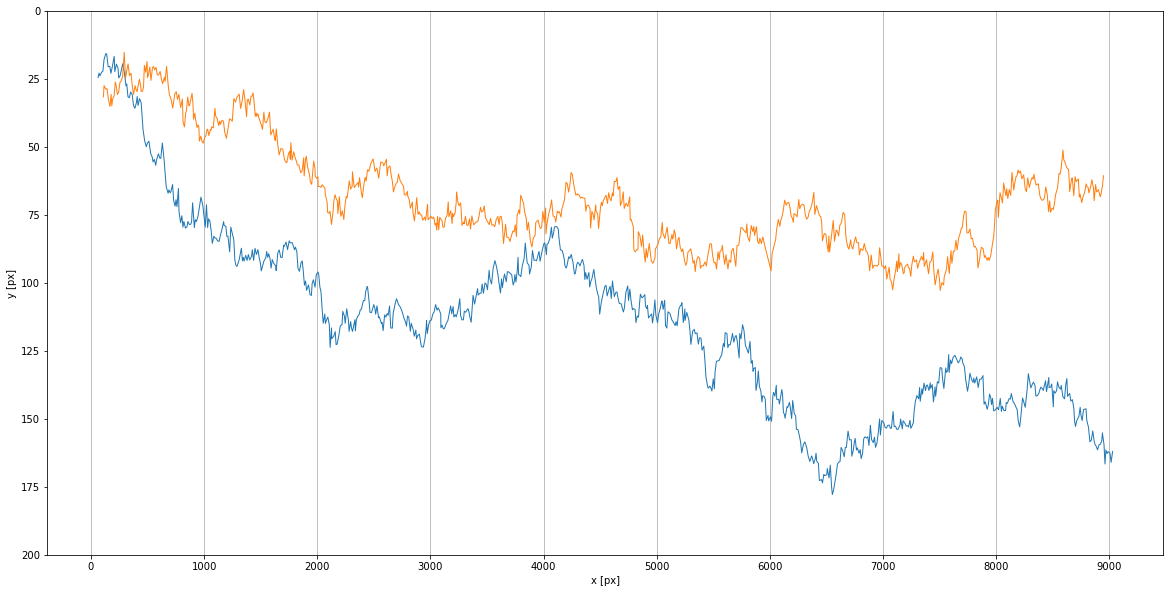

In [35]:
plt.figure(figsize=(20, 10))
plt.grid(True, axis='x')
plt.xticks(np.arange(0, max(top['x'])+1, 1000.0))
plt.ylim(0, 200)
tp.plot_traj(top)

**Analyse Bottom**

In [36]:
bottom.describe()

,y,x,frame,particle
count,3200.000000,3200.000000,3200.00000,3200.000000
mean,137.680046,4392.376980,399.50000,12.500000
std,41.892480,2512.624307,230.97602,1.118209
min,15.437867,31.206029,0.00000,11.000000
25%,111.917488,2215.992326,199.75000,11.750000
50%,155.502694,4384.494667,399.50000,12.500000
75%,167.014834,6556.735970,599.25000,13.250000
max,188.012413,8909.539660,799.00000,14.000000


Tracked particles on first frame


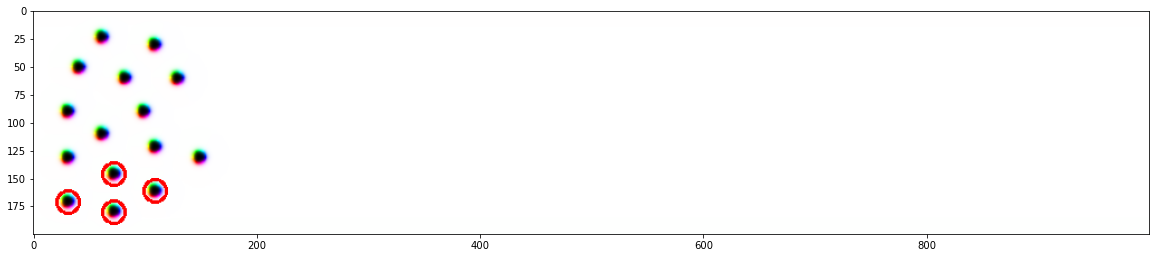

In [37]:
show_tracked(bottom)

Here skyrmions seem to behave a bit differently from the ones in the top quarter as 3 of the 4 skyrmions mostly stay in the bottom half, hence it seems like the strongest interactions are among the skyrmoins in the sub-ensable rather than with all the further ones as well.

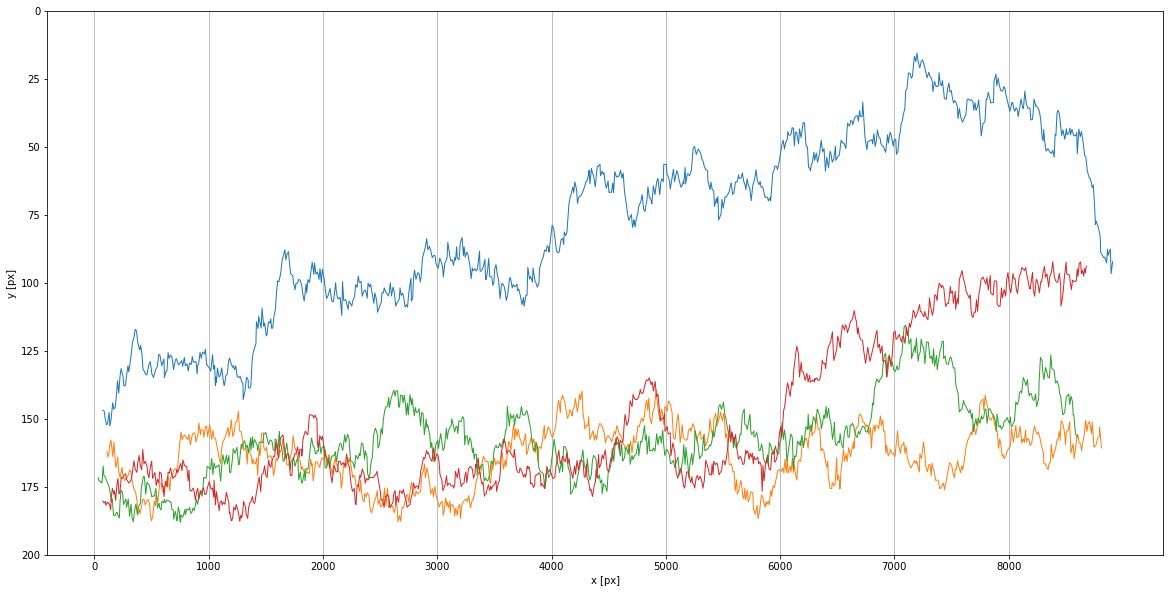

In [38]:
plt.figure(figsize=(20, 10))
plt.grid(True, axis='x')
plt.xticks(np.arange(0, max(bottom['x'])+1, 1000.0))
plt.ylim(0, 200)
tp.plot_traj(bottom)

**Analyse Centre**

In [39]:
centre.describe()

,y,x,frame,particle
count,2400.000000,2400.000000,2400.000000,2400.000000
mean,124.494654,4384.496409,399.500000,6.000000
std,38.239116,2514.763499,230.988055,0.816667
min,20.971020,31.088248,0.000000,5.000000
25%,96.921945,2203.571816,199.750000,5.000000
50%,126.848526,4355.232439,399.500000,6.000000
75%,156.733882,6549.055436,599.250000,7.000000
max,186.792020,8844.332414,799.000000,7.000000


Tracked particles on first frame


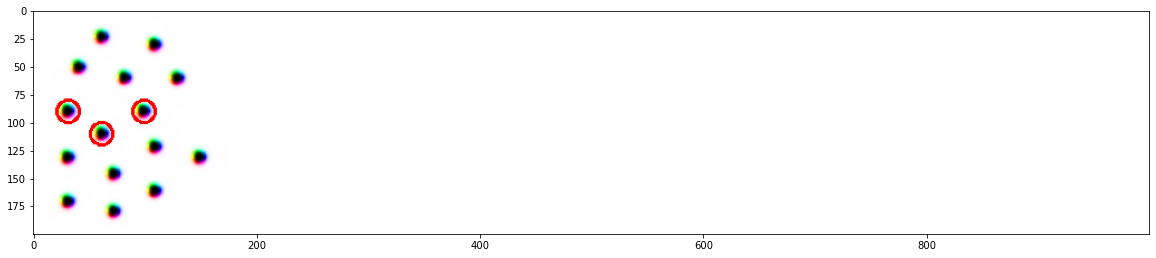

In [40]:
show_tracked(centre)

The middle quarter is quite interesting as one skyrmion seems to almost move independently of the other two, but the lower ones seem to be moving almost together in the second half of the plot.

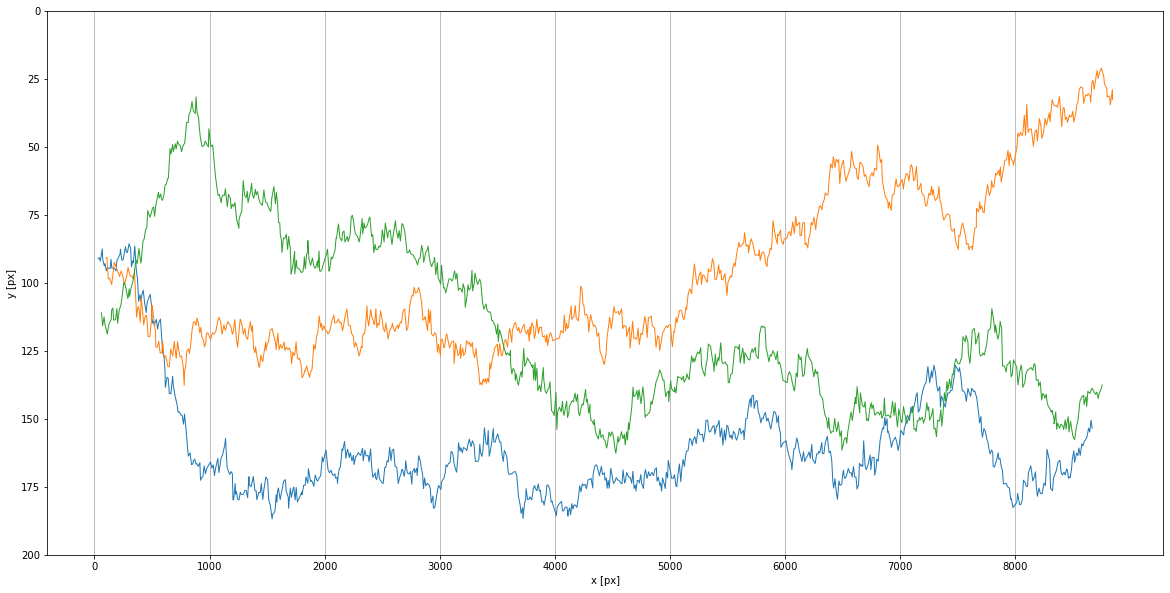

In [41]:
plt.figure(figsize=(20, 10))
plt.grid(True, axis='x')
plt.xticks(np.arange(0, max(centre['x'])+1, 1000.0))
plt.ylim(0, 200)
tp.plot_traj(centre)

## Experiment 4: linear regression with randomly chosen half of the particles and predict others

**Let's use half of the particles to train and the rest to test**

In [42]:
no_skyrmions = data[data['frame'] == 0].shape[0]

ids = list(range(0, no_skyrmions))

train_ids = random.sample(ids, k=7)
ids = [x for x in ids if x not in train_ids]

test_ids = random.sample(ids, k=7)

train_data = data[data['particle'].isin(train_ids)]
test_data = data[data['particle'].isin(test_ids)]

**Train data**
Tracked particles on first frame


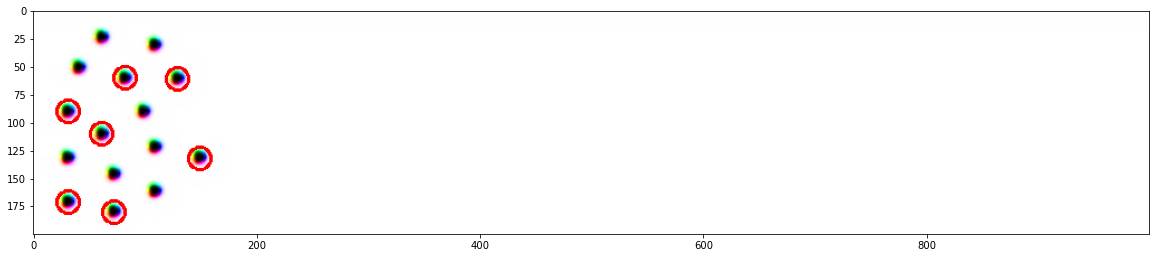

**Test data**
Tracked particles on first frame


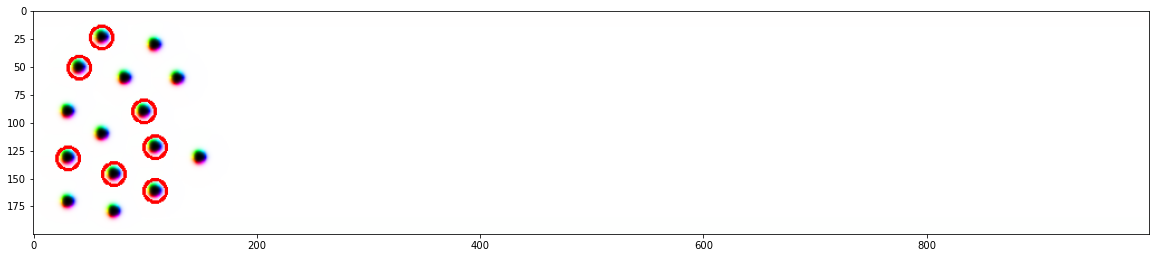

In [43]:
print('**Train data**')
show_tracked(train_data)
print('**Test data**')
show_tracked(test_data)

In [44]:
train_frames = get_frames(train_data)
test_frames = get_frames(test_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:03<00:00, 250.67it/s]


In [45]:
# data in columns ['frame', 'next_frame']
train_df = pd.DataFrame(columns=['frame', 'next_frame'])
test_df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(train_frames)):
    train_df = train_df.append({'frame': train_frames[i-1], 'next_frame': train_frames[i]}, ignore_index=True)
    
for i in range(1, len(test_frames)):
    test_df = test_df.append({'frame': test_frames[i-1], 'next_frame': test_frames[i]}, ignore_index=True)
    
X_train = train_df['frame'].tolist()
y_train = train_df['next_frame'].tolist()
X_test = test_df['frame'].tolist()
y_test = test_df['next_frame'].tolist()

In [46]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [47]:
print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test)

The model performance for X_train
--------------------------------------
RMSE is 3.5026871930679735
R2 score is 0.9886340734407384


The model performance for X_test
--------------------------------------
RMSE is 7.686350171819663
R2 score is 0.9607501257281672




This approach is not good as it requires the training and testing sets to contain the same number of skyrmions, but what if I wanna train with 60% and test with 40%? Also if the number of skyrmions is odd, one skyrmion will be left out.

## Experiment 5: linear regression with top half of the particles and predict others and vice versa

**Select the top half for linear regression and bottom for testing**

In [48]:
train_ids = data[data['frame'] == 0].nsmallest(7, 'y')['particle'].tolist()
test_ids = data[data['frame'] == 0].nlargest(7, 'y')['particle'].tolist()

train_data = data[data['particle'].isin(train_ids)]
test_data = data[data['particle'].isin(test_ids)]

**Train data**
Tracked particles on first frame


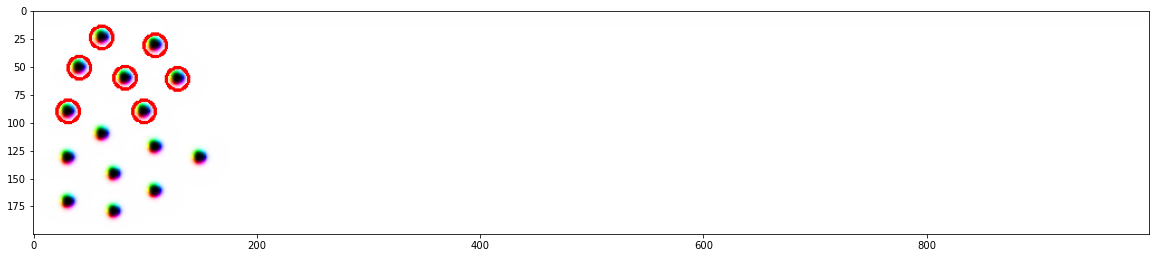

**Test data**
Tracked particles on first frame


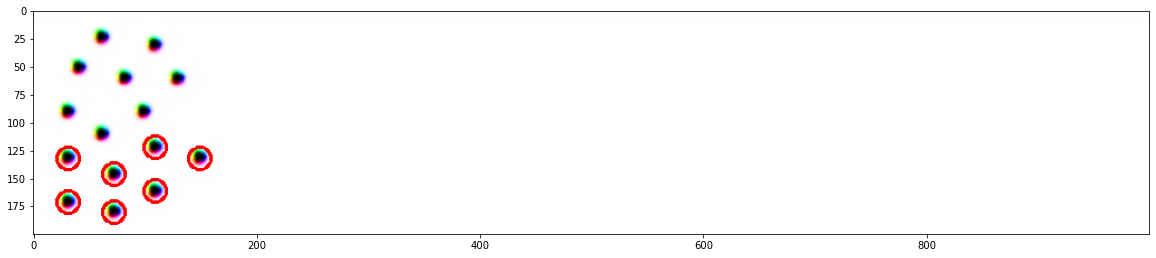

In [49]:
print('**Train data**')
show_tracked(train_data)
print('**Test data**')
show_tracked(test_data)

In [50]:
train_frames = get_frames(train_data)
test_frames = get_frames(test_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:03<00:00, 252.01it/s]


In [51]:
# data in columns ['frame', 'next_frame']
train_df = pd.DataFrame(columns=['frame', 'next_frame'])
test_df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(train_frames)):
    train_df = train_df.append({'frame': train_frames[i-1], 'next_frame': train_frames[i]}, ignore_index=True)
    
for i in range(1, len(test_frames)):
    test_df = test_df.append({'frame': test_frames[i-1], 'next_frame': test_frames[i]}, ignore_index=True)
    
X_train = train_df['frame'].tolist()
y_train = train_df['next_frame'].tolist()
X_test = test_df['frame'].tolist()
y_test = test_df['next_frame'].tolist()

In [52]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [53]:
print("The model performance for training set")
evaluate(X_train, y_train)

print("The model performance for testing set")
evaluate(X_test, y_test)

The model performance for training set
--------------------------------------
RMSE is 3.5175656804393065
R2 score is 0.9889956708566536


The model performance for testing set
--------------------------------------
RMSE is 12.203441595419633
R2 score is 0.8298237501520946




array([[ 130.99533188,  114.641387  ,   43.10256063, ...,  162.91709596,
          74.68496244,  170.51615662],
       [ 143.22837321,  112.45346247,   51.09464292, ...,  164.00596748,
          86.77990592,  171.60649712],
       [ 156.39559949,  112.61163596,   60.68535735, ...,  163.97989314,
          97.79596532,  170.86747067],
       ...,
       [9073.50079085,  117.6998221 , 8749.0830632 , ...,  132.12612304,
        8673.76313832,   88.84871863],
       [9091.26934384,  117.77612172, 8762.23672714, ...,  132.25936611,
        8680.19124711,   86.75512824],
       [9098.43418541,  114.24766633, 8770.63825939, ...,  138.2477053 ,
        8688.14373718,   88.07951025]])

**Select the top half for linear regrassion and bottom for testing**

In [54]:
train_ids = data[data['frame'] == 0].nlargest(7, 'y')['particle'].tolist()
test_ids = data[data['frame'] == 0].nsmallest(7, 'y')['particle'].tolist()

train_data = data[data['particle'].isin(train_ids)]
test_data = data[data['particle'].isin(test_ids)]

**Train data**
Tracked particles on first frame


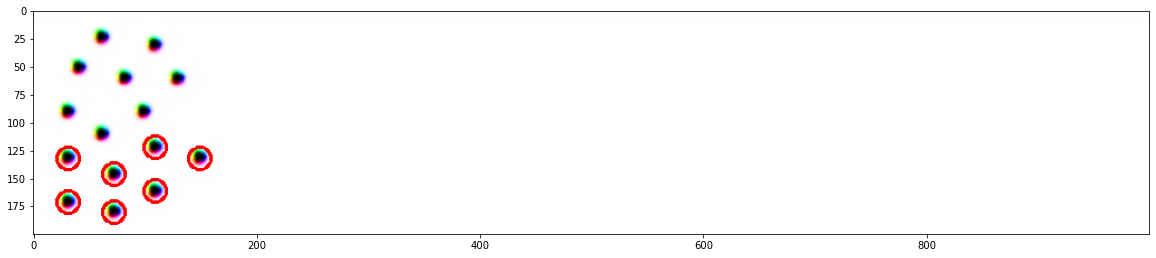

**Test data**
Tracked particles on first frame


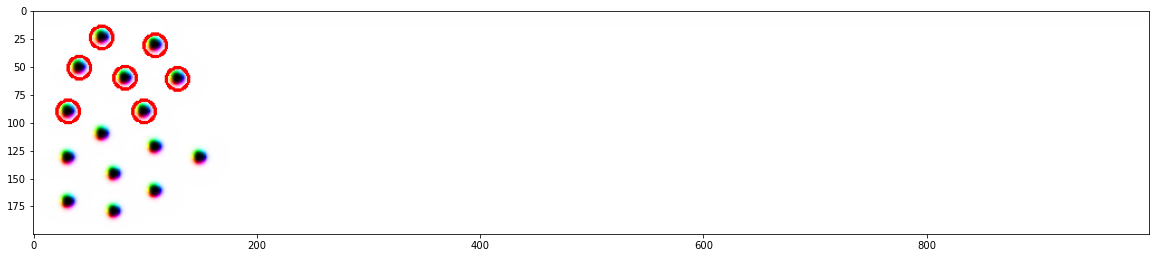

In [55]:
print('**Train data**')
show_tracked(train_data)
print('**Test data**')
show_tracked(test_data)

In [56]:
train_frames = get_frames(train_data)
test_frames = get_frames(test_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:03<00:00, 257.76it/s]


In [57]:
# data in columns ['frame', 'next_frame']
train_df = pd.DataFrame(columns=['frame', 'next_frame'])
test_df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(train_frames)):
    train_df = train_df.append({'frame': train_frames[i-1], 'next_frame': train_frames[i]}, ignore_index=True)
    
for i in range(1, len(test_frames)):
    test_df = test_df.append({'frame': test_frames[i-1], 'next_frame': test_frames[i]}, ignore_index=True)
    
X_train = train_df['frame'].tolist()
y_train = train_df['next_frame'].tolist()
X_test = test_df['frame'].tolist()
y_test = test_df['next_frame'].tolist()

In [58]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [59]:
print("The model performance for training set")
evaluate(X_train, y_train)

print("The model performance for testing set")
evaluate(X_test, y_test)

The model performance for training set
--------------------------------------
RMSE is 3.5031610859735456
R2 score is 0.984826908505804


The model performance for testing set
--------------------------------------
RMSE is 11.126207357629763
R2 score is 0.8536516336490817




array([[  76.82565416,   32.96104464,  109.70582543, ...,  105.76459841,
         112.83551951,   94.11647774],
       [  85.86155537,   31.4958658 ,  116.66440041, ...,  105.14963684,
         122.14556088,   93.85496103],
       [  93.65515941,   32.49730697,  131.65365108, ...,  106.75723489,
         133.71701088,  101.26740418],
       ...,
       [9004.53310012,  164.68980744, 8905.26597451, ...,  155.95759123,
        8832.48049217,   35.25665024],
       [9021.71649002,  165.27772522, 8910.76744594, ...,  157.17164397,
        8836.7696563 ,   37.0840287 ],
       [9031.53628031,  168.59919036, 8925.65844067, ...,  153.40278705,
        8854.34363081,   31.70289081]])

## Experiment 6: train on 5 particles chosen at random and predict the other 10 (in two sets of 5)

In [60]:
ids = list(range(0, no_skyrmions))

train_ids = random.sample(ids, k=5)
ids = [x for x in ids if x not in train_ids]

test_1_ids = random.sample(ids, k=5)
ids = [x for x in ids if x not in test_1_ids]

test_2_ids = ids

In [61]:
train_data = data[data['particle'].isin(train_ids)]
test_1_data = data[data['particle'].isin(test_1_ids)]
test_2_data = data[data['particle'].isin(test_2_ids)]

**Train data**
Tracked particles on first frame


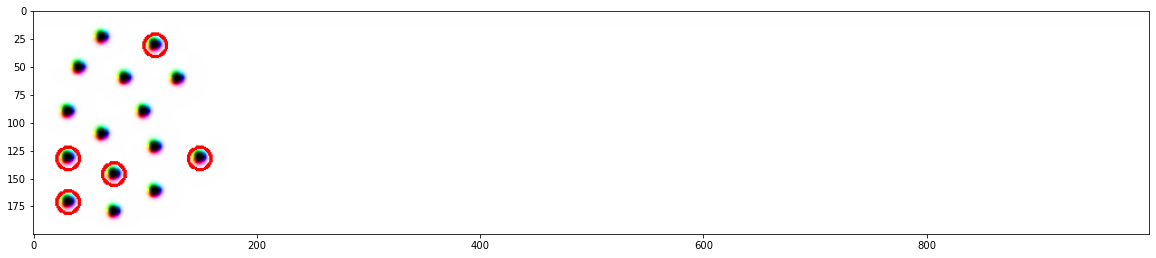

**Test data 1**
Tracked particles on first frame


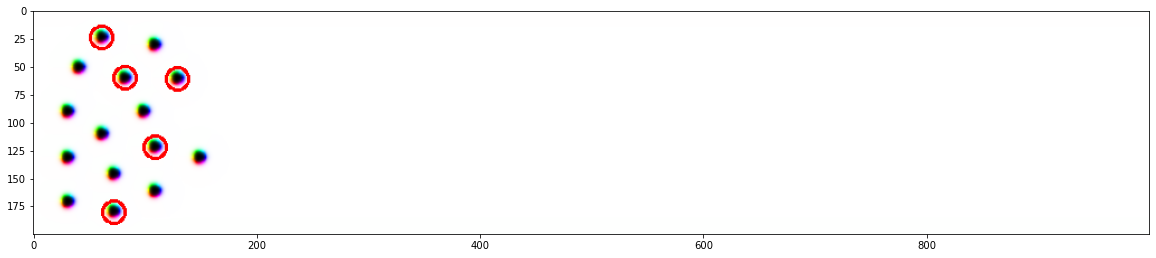

**Test data 2**
Tracked particles on first frame


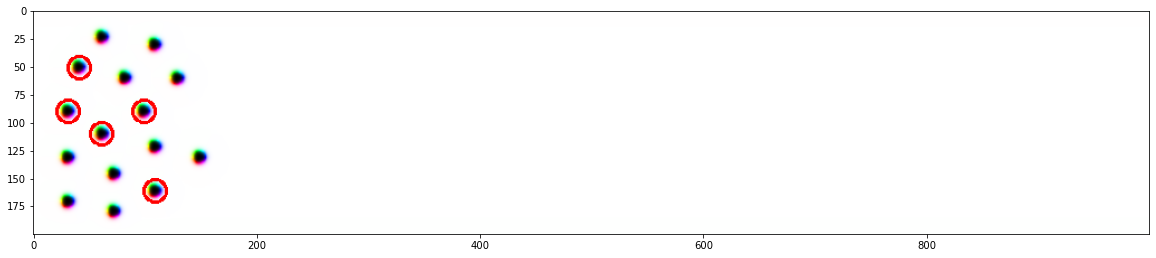

In [62]:
print('**Train data**')
show_tracked(train_data)
print('**Test data 1**')
show_tracked(test_1_data)
print('**Test data 2**')
show_tracked(test_2_data)

In [63]:
train_frames = get_frames(train_data)
test_1_frames = get_frames(test_1_data)
test_2_frames = get_frames(test_2_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 346.79it/s]


In [64]:
# data in columns ['frame', 'next_frame']
train_df = pd.DataFrame(columns=['frame', 'next_frame'])
test_1_df = pd.DataFrame(columns=['frame', 'next_frame'])
test_2_df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(train_frames)):
    train_df = train_df.append({'frame': train_frames[i-1], 'next_frame': train_frames[i]}, ignore_index=True)
    
for i in range(1, len(test_1_frames)):
    test_1_df = test_1_df.append({'frame': test_1_frames[i-1], 'next_frame': test_1_frames[i]}, ignore_index=True)
    
for i in range(1, len(test_2_frames)):
    test_2_df = test_2_df.append({'frame': test_2_frames[i-1], 'next_frame': test_2_frames[i]}, ignore_index=True)
    
X_train = train_df['frame'].tolist()
y_train = train_df['next_frame'].tolist()
X_1_test = test_1_df['frame'].tolist()
y_1_test = test_1_df['next_frame'].tolist()
X_2_test = test_2_df['frame'].tolist()
y_2_test = test_2_df['next_frame'].tolist()

In [65]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [66]:
print("The model performance for training set")
evaluate(X_train, y_train)

print("The model performance for testing set 1")
evaluate(X_1_test, y_1_test)

print("The model performance for testing set 2")
evaluate(X_2_test, y_2_test)

The model performance for training set
--------------------------------------
RMSE is 3.5850166381930966
R2 score is 0.9880590439195356


The model performance for testing set 1
--------------------------------------
RMSE is 5.565817921759895
R2 score is 0.9762513864046533


The model performance for testing set 2
--------------------------------------
RMSE is 7.2076913639601985
R2 score is 0.9360626279914935




array([[  56.31936652,   45.35538061,   40.72387213, ...,  112.11848701,
         112.28790439,  163.76722056],
       [  71.84711957,   42.77473448,   50.05764059, ...,  116.70033257,
         119.9467927 ,  165.67691311],
       [  84.74508356,   43.51101912,   60.08471196, ...,  113.44910733,
         131.1623547 ,  164.34407352],
       ...,
       [8800.00656583,   66.03853234, 8640.05080297, ...,  138.90392511,
        8774.4239947 ,  157.62814581],
       [8807.95160486,   65.34371956, 8649.57452741, ...,  137.10874617,
        8790.25990658,  156.75872422],
       [8817.92414773,   63.71470703, 8661.63066572, ...,  135.45058288,
        8790.49274016,  153.81529718]])

## Experiment 7: train on 5 particles (top, centre, bottom) and predict the other 10 (in two sets of 5)

In [67]:
top_ids = data[data['frame'] == 0].nsmallest(5, 'y')['particle'].tolist()
bottom_ids = data[data['frame'] == 0].nlargest(5, 'y')['particle'].tolist()

ids = list(range(0, no_skyrmions))

centre_ids = [x for x in ids if x not in top_ids and x not in bottom_ids]

top_data = data[data['particle'].isin(top_ids)]
centre_data = data[data['particle'].isin(centre_ids)]
bottom_data = data[data['particle'].isin(bottom_ids)]

**Top data**
Tracked particles on first frame


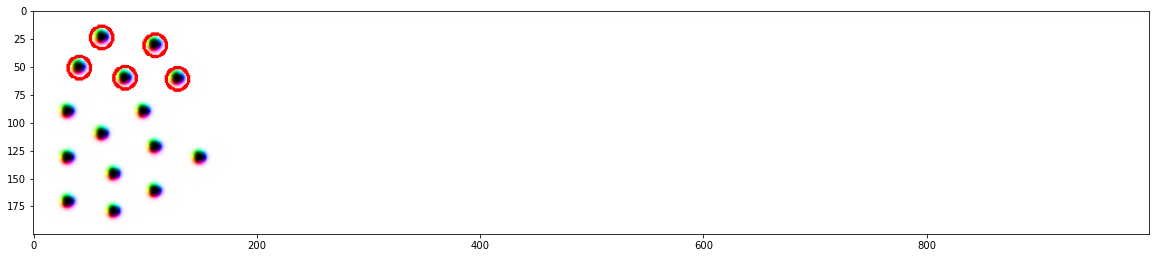

**Centre data**
Tracked particles on first frame


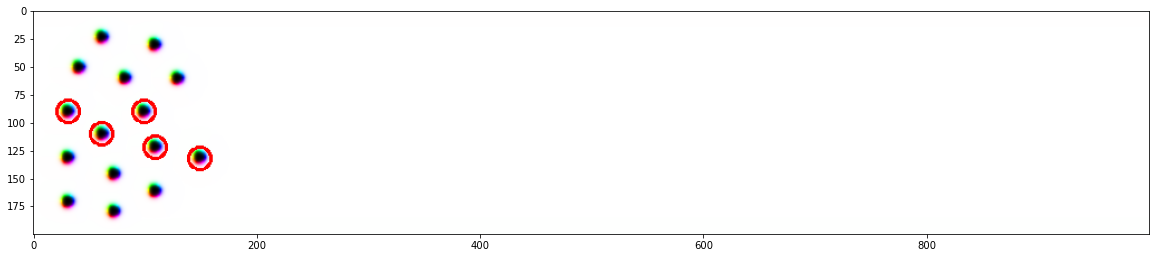

**Bottom data**
Tracked particles on first frame


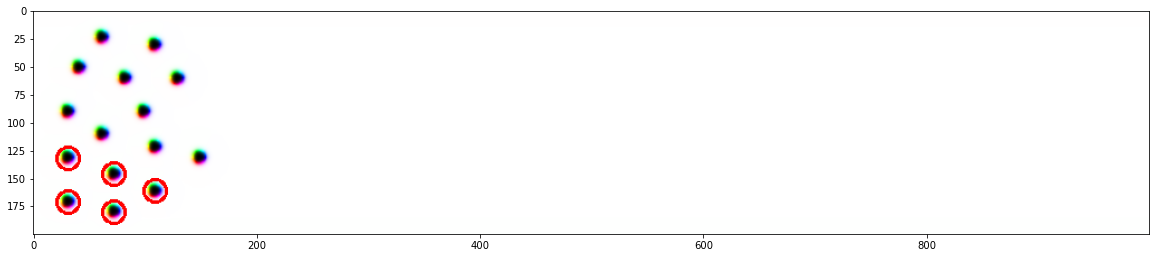

In [68]:
print('**Top data**')
show_tracked(top_data)
print('**Centre data**')
show_tracked(centre_data)
print('**Bottom data**')
show_tracked(bottom_data)

In [69]:
top_frames = get_frames(top_data)
centre_frames = get_frames(centre_data)
bottom_frames = get_frames(bottom_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 350.74it/s]


In [70]:
# data in columns ['frame', 'next_frame']
top_df = pd.DataFrame(columns=['frame', 'next_frame'])
centre_df = pd.DataFrame(columns=['frame', 'next_frame'])
bottom_df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(top_frames)):
    top_df = top_df.append({'frame': top_frames[i-1], 'next_frame': top_frames[i]}, ignore_index=True)
    
for i in range(1, len(centre_frames)):
    centre_df = centre_df.append({'frame': centre_frames[i-1], 'next_frame': centre_frames[i]}, ignore_index=True)

for i in range(1, len(bottom_frames)):
    bottom_df = bottom_df.append({'frame': bottom_frames[i-1], 'next_frame': bottom_frames[i]}, ignore_index=True)

X_top = top_df['frame'].tolist()
y_top = top_df['next_frame'].tolist()
X_centre = centre_df['frame'].tolist()
y_centre = centre_df['next_frame'].tolist()
X_bottom = bottom_df['frame'].tolist()
y_bottom = bottom_df['next_frame'].tolist()

**Train on top**

In [71]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_top, y_top)

LinearRegression()

In [72]:
print("The model performance for training set (top)")
evaluate(X_top, y_top)

print("The model performance for testing set (centre)")
evaluate(X_centre, y_centre)

print("The model performance for testing set (bottom)")
evaluate(X_bottom, y_bottom)

The model performance for training set (top)
--------------------------------------
RMSE is 3.5384109586777464
R2 score is 0.9879133046376237


The model performance for testing set (centre)
--------------------------------------
RMSE is 8.366081179130328
R2 score is 0.9525343555656185


The model performance for testing set (bottom)
--------------------------------------
RMSE is 8.480387930206998
R2 score is 0.9032439896627181




array([[  50.64947093,  125.97579313,   80.13595501, ...,  160.33874776,
          82.43353099,  175.9141672 ],
       [  59.16829397,  131.43536144,   92.34429361, ...,  161.54241727,
          94.47147589,  176.48832337],
       [  68.44760927,  127.9439506 ,  102.41036836, ...,  161.5860539 ,
         105.85768621,  175.92263934],
       ...,
       [8730.41657622,  103.37555092, 8879.80378032, ...,  147.43993405,
        8667.33339873,  100.48865654],
       [8743.16254024,  100.16854652, 8899.36620123, ...,  147.70481517,
        8672.74747948,   97.90554997],
       [8751.83038538,  107.96115967, 8905.8117492 , ...,  154.24389496,
        8681.15598081,   99.08758262]])

**Train on centre**

In [73]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_centre, y_centre)

LinearRegression()

In [74]:
print("The model performance for training set (centre)")
evaluate(X_centre, y_centre)

print("The model performance for testing set (top)")
evaluate(X_top, y_top)

print("The model performance for testing set (bottom)")
evaluate(X_bottom, y_bottom)

The model performance for training set (centre)
--------------------------------------
RMSE is 3.6086960518467164
R2 score is 0.9915238403916924


The model performance for testing set (top)
--------------------------------------
RMSE is 11.761901504967794
R2 score is 0.8922935750143198


The model performance for testing set (bottom)
--------------------------------------
RMSE is 11.146758236691758
R2 score is 0.9305108391186965




array([[  36.40898122,  130.42118865,   84.1222881 , ...,  172.08400495,
          86.54589499,  174.43099218],
       [  44.63314617,  135.41261444,   96.41596982, ...,  173.07392093,
          98.67025721,  175.22556595],
       [  53.93201494,  132.16857739,  106.39455487, ...,  173.13595006,
         109.88987517,  174.60352135],
       ...,
       [8709.10805441,  104.70752228, 8881.8348688 , ...,  157.91598069,
        8679.96558833,   86.79795697],
       [8722.36395265,  101.36675791, 8901.22380982, ...,  158.27131541,
        8685.54363353,   83.93260058],
       [8729.61836268,  108.78151708, 8907.59006029, ...,  164.25032512,
        8693.73431924,   85.47489708]])

**Train on bottom**

In [75]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_bottom, X_bottom)

LinearRegression()

In [76]:
print("The model performance for training set (bottom)")
evaluate(X_bottom, y_bottom)

print("The model performance for testing set (centre)")
evaluate(X_centre, y_centre)

print("The model performance for testing set (top)")
evaluate(X_top, y_top)

The model performance for training set (bottom)
--------------------------------------
RMSE is 8.473243898917884
R2 score is 0.9814422797040983


The model performance for testing set (centre)
--------------------------------------
RMSE is 8.626416563199296
R2 score is 0.9911342251604113


The model performance for testing set (top)
--------------------------------------
RMSE is 8.63798663086226
R2 score is 0.9873691487229118




array([[  61.80999151,   24.42004672,  109.00946255, ...,   60.99468888,
         129.25258611,   61.57299776],
       [  70.80009877,   22.78610623,  115.03445141, ...,   63.38895895,
         142.17640321,   68.74349534],
       [  78.53846154,   23.79722076,  130.69276551, ...,   62.62884257,
         149.43550369,   63.55870481],
       ...,
       [8990.15736707,  162.03706008, 8920.93911974, ...,  133.41478998,
        9016.42434498,   80.57434498],
       [9007.54035336,  162.55978799, 8926.05508703, ...,  128.35473348,
        9028.39193641,   82.42931825],
       [9017.58639515,  165.97686308, 8941.78148615, ...,  133.69698871,
        9042.89820138,   76.6062556 ]])